## Diffraction Spectrum of Liquid-Crystal Polarization Gratings

As a final demonstration of mode decomposition, we compute the diffraction spectrum of a [liquid-crystal](https://en.wikipedia.org/wiki/Liquid_crystal) polarization grating. These types of beam splitters use [birefringence](https://en.wikipedia.org/wiki/Birefringence) to produce diffraction orders which are [circularly polarized](https://en.wikipedia.org/wiki/Circular_polarization). We will investigate two kinds of polarization gratings: (1) a homogeneous [uniaxial](https://en.wikipedia.org/wiki/Birefringence#Uniaxial_materials) grating (commonly known as a circular-polarization grating), and (2) a [twisted-nematic](https://en.wikipedia.org/wiki/Liquid_crystal#Chiral_phases) bilayer grating as described in [Optics Letters, Vol. 33, No. 20, pp. 2287-9, 2008](https://www.osapublishing.org/ol/abstract.cfm?uri=ol-33-20-2287) ([pdf](https://www.imagineoptix.com/cms/wp-content/uploads/2017/01/OL_08_Oh-broadband_PG.pdf)). The homogeneous uniaxial grating is just a special case of the twisted-nematic grating with a nematic [director](https://en.wikipedia.org/wiki/Liquid_crystal#Director) rotation angle of φ=0°.

A schematic of the grating geometry is shown below. The grating is a 2d slab in the *xy*-plane with two parameters: birefringence (Δn) and thickness (d). The twisted-nematic grating consists of two layers of thickness d each with equal and opposite rotation angles of φ=70° for the nematic director. Both gratings contain only three diffraction orders: m=0, ±1. The m=0 order is linearly polarized and the m=±1 orders are circularly polarized with opposite chirality. For the uniaxial grating, the diffraction efficiencies for a mode with wavelength λ can be computed analytically: η<sub>0</sub>=cos<sup>2</sup>(πΔnd/λ), η<sub>±1</sub>=0.5sin<sup>2</sup>(πΔnd/λ). The derivation of these formulas is presented in [Optics Letters, Vol. 24, No. 9, pp. 584-6, 1999](https://www.osapublishing.org/ol/abstract.cfm?uri=ol-24-9-584). We will verify these analytic results and also demonstrate that the twisted-nematic grating produces a broader bandwidth response for the ±1 orders than the homogeneous uniaxial grating. An important property of these polarization gratings for e.g. display applications is that for a circular-polarized input planewave and phase delay (Δnd/λ) of nearly 0.5, there is only a single diffraction order (+1 or -1) with *opposite* chiraity to that of the input. This is also demonstrated below.

![](https://meep.readthedocs.io/en/latest/images/polarization_grating_schematic.png)

In this example, the input is a linear-polarized planewave pulse at normal incidence with center wavelength of λ=0.54 μm. The linear polarization is in the *yz*-plane with a rotation angle of 45° counter clockwise around the *x* axis. Two sets of mode coefficients are computed in the air region adjacent to the grating for each orthogonal polarization: `ODD_Z+EVEN_Y` and `EVEN_Z+ODD_Y`, which correspond to +k<sub>y</sub> + -k<sub>y</sub> (cosine) and +k<sub>y</sub> - -k<sub>y</sub> (sine) modes. From these coefficients for linear-polarized modes, the power in the circular-polarized modes can be computed: |ODD_Z+EVEN_Y|<sup>2</sup>+|EVEN_Z+ODD_Y|<sup>2</sup>. The power is identical for the two circular-polarized modes with opposite chiralities since the input is linearly polarized and at normal incidence. The transmittance for the diffraction orders are computed from the mode coefficients. As usual, this requires a separate normalization run to compute the power of the input planewave.

The main part of the script is the function `pol_grating` which computes the mode coefficients for a grating with thickness `d`, twisted-nematic rotation angle `ph`, and periodicity `gp`. The anisotropic permittivity of the grating is specified using the [material function](https://meep.readthedocs.io/en/latest/Python_User_Interface/#medium) `lc_mat` which involves a position-dependent rotation of the diagonal ε tensor about the *x*-axis. For φ=0°, the nematic director is oriented along the *z*-axis: E<sub>z</sub> has a larger permittivity than E<sub>y</sub> where the birefringence (Δn) is 0.159. The grating has a periodicity of Λ=6.5 μm in the *y* direction.

In [1]:
import meep as mp
import math
import numpy as np
import matplotlib.pyplot as plt

resolution = 30  # pixels/μm

dpml = 1.0  # PML thickness
dsub = 1.0  # substrate thickness
dpad = 1.0  # padding thickness

k_point = mp.Vector3(0, 0, 0)

pml_layers = [mp.PML(thickness=dpml, direction=mp.X)]

n_0 = 1.55
delta_n = 0.159
epsilon_diag = mp.Matrix(
    mp.Vector3(n_0**2, 0, 0),
    mp.Vector3(0, n_0**2, 0),
    mp.Vector3(0, 0, (n_0 + delta_n) ** 2),
)

wvl = 0.54  # center wavelength
fcen = 1 / wvl  # center frequency


def pol_grating(d, ph, gp, nmode):
    sx = dpml + dsub + d + d + dpad + dpml
    sy = gp

    cell_size = mp.Vector3(sx, sy, 0)

    # twist angle of nematic director; from equation 1b
    def phi(p):
        xx = p.x - (-0.5 * sx + dpml + dsub)
        if (xx >= 0) and (xx <= d):
            return math.pi * p.y / gp + ph * xx / d
        else:
            return math.pi * p.y / gp - ph * xx / d + 2 * ph

    # return the anisotropic permittivity tensor for a uniaxial, twisted nematic liquid crystal
    def lc_mat(p):
        # rotation matrix for rotation around x axis
        Rx = mp.Matrix(
            mp.Vector3(1, 0, 0),
            mp.Vector3(0, math.cos(phi(p)), math.sin(phi(p))),
            mp.Vector3(0, -math.sin(phi(p)), math.cos(phi(p))),
        )
        lc_epsilon = Rx * epsilon_diag * Rx.transpose()
        lc_epsilon_diag = mp.Vector3(lc_epsilon[0].x, lc_epsilon[1].y, lc_epsilon[2].z)
        lc_epsilon_offdiag = mp.Vector3(
            lc_epsilon[1].x, lc_epsilon[2].x, lc_epsilon[2].y
        )
        return mp.Medium(
            epsilon_diag=lc_epsilon_diag, epsilon_offdiag=lc_epsilon_offdiag
        )

    geometry = [
        mp.Block(
            center=mp.Vector3(-0.5 * sx + 0.5 * (dpml + dsub)),
            size=mp.Vector3(dpml + dsub, mp.inf, mp.inf),
            material=mp.Medium(index=n_0),
        ),
        mp.Block(
            center=mp.Vector3(-0.5 * sx + dpml + dsub + d),
            size=mp.Vector3(2 * d, mp.inf, mp.inf),
            material=lc_mat,
        ),
    ]

    # linear-polarized planewave pulse source
    src_pt = mp.Vector3(-0.5 * sx + dpml + 0.3 * dsub, 0, 0)
    sources = [
        mp.Source(
            mp.GaussianSource(fcen, fwidth=0.05 * fcen),
            component=mp.Ez,
            center=src_pt,
            size=mp.Vector3(0, sy, 0),
        ),
        mp.Source(
            mp.GaussianSource(fcen, fwidth=0.05 * fcen),
            component=mp.Ey,
            center=src_pt,
            size=mp.Vector3(0, sy, 0),
        ),
    ]

    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        k_point=k_point,
        sources=sources,
        default_material=mp.Medium(index=n_0),
    )

    tran_pt = mp.Vector3(0.5 * sx - dpml - 0.5 * dpad, 0, 0)
    tran_flux = sim.add_flux(
        fcen, 0, 1, mp.FluxRegion(center=tran_pt, size=mp.Vector3(0, sy, 0))
    )

    sim.run(until_after_sources=100)

    input_flux = mp.get_fluxes(tran_flux)

    sim.reset_meep()

    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        k_point=k_point,
        sources=sources,
        geometry=geometry,
    )

    tran_flux = sim.add_flux(
        fcen, 0, 1, mp.FluxRegion(center=tran_pt, size=mp.Vector3(0, sy, 0))
    )

    sim.run(until_after_sources=300)

    res1 = sim.get_eigenmode_coefficients(
        tran_flux, range(1, nmode + 1), eig_parity=mp.ODD_Z + mp.EVEN_Y
    )
    res2 = sim.get_eigenmode_coefficients(
        tran_flux, range(1, nmode + 1), eig_parity=mp.EVEN_Z + mp.ODD_Y
    )
    angles = [math.degrees(math.acos(kdom.x / fcen)) for kdom in res1.kdom]

    return input_flux[0], angles, res1.alpha[:, 0, 0], res2.alpha[:, 0, 0];

The properties of the two gratings are computed over the thickness range of 0.1 to 3.4 μm corresponding to phase delays (Δnd/λ) of approximately 0 to 1.

In [2]:
ph_uniaxial = 0  # chiral layer twist angle for uniaxial grating
ph_twisted = 70  # chiral layer twist angle for bilayer grating
gp = 6.5  # grating period
nmode = 5  # number of mode coefficients to compute
dd = np.arange(0.2, 3.5, 0.2)  # chiral layer thickness

m0_uniaxial = np.zeros(dd.size)
m1_uniaxial = np.zeros(dd.size)
ang_uniaxial = np.zeros(dd.size)

m0_twisted = np.zeros(dd.size)
m1_twisted = np.zeros(dd.size)
ang_twisted = np.zeros(dd.size)

for k in range(len(dd)):
    input_flux, angles, coeffs1, coeffs2 = pol_grating(
        0.5 * dd[k], math.radians(ph_uniaxial), gp, nmode
    )
    tran = (abs(coeffs1) ** 2 + abs(coeffs2) ** 2) / input_flux
    for m in range(nmode):
        print("tran (uniaxial):, {}, {:.2f}, {:.5f}".format(m, angles[m], tran[m]))
    m0_uniaxial[k] = tran[0]
    m1_uniaxial[k] = tran[1]
    ang_uniaxial[k] = angles[1]

    input_flux, angles, coeffs1, coeffs2 = pol_grating(
        dd[k], math.radians(ph_twisted), gp, nmode
    )
    tran = (abs(coeffs1) ** 2 + abs(coeffs2) ** 2) / input_flux
    for m in range(nmode):
        print("tran (twisted):, {}, {:.2f}, {:.5f}".format(m, angles[m], tran[m]))
    m0_twisted[k] = tran[0]
    m1_twisted[k] = tran[1]
    ang_twisted[k] = angles[1]

-----------
Initializing structure...
time for choose_chunkdivision = 5.79357e-05 s
Working in 2D dimensions.
Computational cell is 4.2 x 6.5 x 0 with resolution 30
time for set_epsilon = 0.0339479 s
-----------
run 0 finished at t = 208.0 (12480 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 2.71797e-05 s
Working in 2D dimensions.
Computational cell is 4.2 x 6.5 x 0 with resolution 30
     block, center = (-1.1,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (-8.32667e-17,0,0)
          size (0.2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.758735 s
-----------
Meep progress: 224.88333333333333/408.0 = 55.1% done in 4.0s, 3.3s to go
on time step 13493 (time=224.883), 0.000296471 s/step
run 0 finished at t = 408.0 (24480 timesteps)
MPB solved for omega_1(1.85185,0,0) = 1.85185 after 65 iters
Dominan

     block, center = (-1.66533e-16,0,0)
          size (0.4,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 3.38153 s
-----------
Meep progress: 100.73333333333333/408.0 = 24.7% done in 4.0s, 12.2s to go
on time step 6044 (time=100.733), 0.00066186 s/step
Meep progress: 201.35/408.0 = 49.4% done in 8.0s, 8.2s to go
on time step 12083 (time=201.383), 0.000662443 s/step
Meep progress: 301.6333333333333/408.0 = 73.9% done in 12.0s, 4.2s to go
on time step 18102 (time=301.7), 0.000664572 s/step
Meep progress: 403.3333333333333/408.0 = 98.9% done in 16.0s, 0.2s to go
on time step 24205 (time=403.417), 0.000655435 s/step
run 0 finished at t = 408.0 (24480 timesteps)
MPB solved for omega_1(1.85185,0,0) = 1.85185 after 53 iters
Dominant planewave for band 1: (1.851852,-0.000000,0.000000)
MPB solved for omega_2(1.85185,0,0) = 1.85823 after 50 iters
MPB solved for omega_2(1.84545,0,0) = 1.85185 after 1 iters
MPB solved for omega_2(1.84545,0,0) = 1.85185 after 1 iters

     block, center = (2.22045e-16,0,0)
          size (0.6,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 4.98919 s
-----------
Meep progress: 98.01666666666667/408.0 = 24.0% done in 4.0s, 12.7s to go
on time step 5881 (time=98.0167), 0.000680194 s/step
Meep progress: 197.98333333333332/408.0 = 48.5% done in 8.0s, 8.5s to go
on time step 11880 (time=198), 0.00066678 s/step
Meep progress: 297.0833333333333/408.0 = 72.8% done in 12.0s, 4.5s to go
on time step 17827 (time=297.117), 0.000672654 s/step
Meep progress: 395.51666666666665/408.0 = 96.9% done in 16.0s, 0.5s to go
on time step 23735 (time=395.583), 0.000677137 s/step
run 0 finished at t = 408.0 (24480 timesteps)
MPB solved for omega_1(1.85185,0,0) = 1.85185 after 70 iters
Dominant planewave for band 1: (1.851852,-0.000000,0.000000)
MPB solved for omega_2(1.85185,0,0) = 1.85823 after 45 iters
MPB solved for omega_2(1.84545,0,0) = 1.85185 after 1 iters
MPB solved for omega_2(1.84545,0,0) = 1.85185 afte

          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (1.11022e-16,0,0)
          size (0.8,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 6.60763 s
-----------
Meep progress: 93.03333333333333/408.0 = 22.8% done in 4.0s, 13.5s to go
on time step 5582 (time=93.0333), 0.00071674 s/step
Meep progress: 188.96666666666667/408.0 = 46.3% done in 8.0s, 9.3s to go
on time step 11340 (time=189), 0.000694738 s/step
Meep progress: 285.1666666666667/408.0 = 69.9% done in 12.0s, 5.2s to go
on time step 17113 (time=285.217), 0.0006929 s/step
Meep progress: 381.0/408.0 = 93.4% done in 16.0s, 1.1s to go
on time step 22865 (time=381.083), 0.000695525 s/step
run 0 finished at t = 408.0 (24480 timesteps)
MPB solved for omega_1(1.85185,0,0) = 1.85185 after 58 iters
Dominant planewave for band 1: (1.851852,-0.000000,0.000000)
MPB solved for omega_2(1.85185,0,0) = 1.85823 after 54 iters
MPB solved for omega_2(1.84545,0,0) = 1.85185 after 1

Working in 2D dimensions.
Computational cell is 5 x 6.5 x 0 with resolution 30
     block, center = (-1.5,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (0,0,0)
          size (1,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 8.54403 s
-----------
Meep progress: 93.58333333333333/408.0 = 22.9% done in 4.0s, 13.4s to go
on time step 5615 (time=93.5833), 0.000712491 s/step
Meep progress: 189.16666666666666/408.0 = 46.4% done in 8.0s, 9.3s to go
on time step 11352 (time=189.2), 0.000697323 s/step
Meep progress: 283.1666666666667/408.0 = 69.4% done in 12.0s, 5.3s to go
on time step 16993 (time=283.217), 0.000709178 s/step
Meep progress: 378.1166666666667/408.0 = 92.7% done in 16.0s, 1.3s to go
on time step 22691 (time=378.183), 0.000702061 s/step
run 0 finished at t = 408.0 (24480 timesteps)
MPB solved for omega_1(1.85185,0,0) = 1.85185 af

run 0 finished at t = 208.0 (12480 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.10352e-05 s
Working in 2D dimensions.
Computational cell is 5.2 x 6.5 x 0 with resolution 30
     block, center = (-1.6,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (-1.11022e-16,0,0)
          size (1.2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 9.882 s
-----------
Meep progress: 92.15/408.0 = 22.6% done in 4.0s, 13.7s to go
on time step 5529 (time=92.15), 0.000723491 s/step
Meep progress: 185.61666666666667/408.0 = 45.5% done in 8.0s, 9.6s to go
on time step 11139 (time=185.65), 0.00071314 s/step
Meep progress: 278.5833333333333/408.0 = 68.3% done in 12.0s, 5.6s to go
on time step 16719 (time=278.65), 0.000716963 s/step
Meep progress: 371.01666666666665/408.0 = 90.9% done in 16.0s, 1.6s to go
on time step 22267 

Computational cell is 5.4 x 6.5 x 0 with resolution 30
time for set_epsilon = 0.0821059 s
-----------
Meep progress: 93.78333333333333/208.0 = 45.1% done in 4.0s, 4.9s to go
on time step 5627 (time=93.7833), 0.000710922 s/step
Meep progress: 189.56666666666666/208.0 = 91.1% done in 8.0s, 0.8s to go
on time step 11376 (time=189.6), 0.000695889 s/step
run 0 finished at t = 208.0 (12480 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.29425e-05 s
Working in 2D dimensions.
Computational cell is 5.4 x 6.5 x 0 with resolution 30
     block, center = (-1.7,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (-1.11022e-16,0,0)
          size (1.4,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 11.8445 s
-----------
Meep progress: 89.43333333333334/408.0 = 21.9% done in 4.0s, 14.2s to go
on time step 5366 (time=89.43

MPB solved for omega_5(1.74661,0,0) = 1.85185 after 1 iters
Dominant planewave for band 5: (1.746613,-0.615385,0.000000)
tran (twisted):, 0, 0.00, 0.00085
tran (twisted):, 1, 4.77, 0.46955
tran (twisted):, 2, 9.56, 0.00000
tran (twisted):, 3, 14.43, 0.00000
tran (twisted):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 0.000133991 s
Working in 2D dimensions.
Computational cell is 5.6 x 6.5 x 0 with resolution 30
time for set_epsilon = 0.096647 s
-----------
Meep progress: 93.56666666666666/208.0 = 45.0% done in 4.0s, 4.9s to go
on time step 5614 (time=93.5667), 0.000712629 s/step
Meep progress: 188.45/208.0 = 90.6% done in 8.0s, 0.8s to go
on time step 11308 (time=188.467), 0.000702542 s/step
run 0 finished at t = 208.0 (12480 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.29425e-05 s
Working in 2D dimensions.
Computational cell is 5.6 x 6.5 x 0 with resolution 30
     block, center = (-1.8,0,0)
          siz

MPB solved for omega_3(1.82612,0,0) = 1.85186 after 1 iters
MPB solved for omega_3(1.82611,0,0) = 1.85185 after 1 iters
Dominant planewave for band 3: (1.826111,-0.307692,0.000000)
MPB solved for omega_4(1.85185,0,0) = 1.9085 after 35 iters
MPB solved for omega_4(1.79347,0,0) = 1.85191 after 1 iters
MPB solved for omega_4(1.79342,0,0) = 1.85185 after 1 iters
MPB solved for omega_4(1.79342,0,0) = 1.85185 after 1 iters
Dominant planewave for band 4: (1.793415,-0.461538,0.000000)
MPB solved for omega_5(1.85185,0,0) = 1.95142 after 27 iters
MPB solved for omega_5(1.74693,0,0) = 1.85215 after 1 iters
MPB solved for omega_5(1.74661,0,0) = 1.85185 after 1 iters
MPB solved for omega_5(1.74661,0,0) = 1.85185 after 1 iters
Dominant planewave for band 5: (1.746613,-0.615385,0.000000)
tran (twisted):, 0, 0.00, 0.00061
tran (twisted):, 1, 4.77, 0.46431
tran (twisted):, 2, 9.56, 0.00000
tran (twisted):, 3, 14.43, 0.00000
tran (twisted):, 4, 19.41, 0.00000
-----------
Initializing structure...
time f

MPB solved for omega_5(1.85185,0,0) = 1.95142 after 29 iters
MPB solved for omega_5(1.74693,0,0) = 1.85215 after 1 iters
MPB solved for omega_5(1.74661,0,0) = 1.85185 after 1 iters
MPB solved for omega_5(1.74661,0,0) = 1.85185 after 1 iters
Dominant planewave for band 5: (1.746613,-0.615385,0.000000)
MPB solved for omega_1(1.85185,0,0) = 1.85185 after 60 iters
Dominant planewave for band 1: (1.851852,-0.000000,0.000000)
MPB solved for omega_2(1.85185,0,0) = 1.85823 after 43 iters
MPB solved for omega_2(1.84545,0,0) = 1.85185 after 1 iters
MPB solved for omega_2(1.84545,0,0) = 1.85185 after 1 iters
Dominant planewave for band 2: (1.845450,-0.153846,0.000000)
MPB solved for omega_3(1.85185,0,0) = 1.87724 after 41 iters
MPB solved for omega_3(1.82612,0,0) = 1.85186 after 1 iters
MPB solved for omega_3(1.82611,0,0) = 1.85185 after 1 iters
Dominant planewave for band 3: (1.826111,-0.307692,0.000000)
MPB solved for omega_4(1.85185,0,0) = 1.9085 after 31 iters
MPB solved for omega_4(1.79347,0

Dominant planewave for band 2: (1.845450,-0.153846,0.000000)
MPB solved for omega_3(1.85185,0,0) = 1.87724 after 38 iters
MPB solved for omega_3(1.82612,0,0) = 1.85186 after 1 iters
MPB solved for omega_3(1.82611,0,0) = 1.85185 after 1 iters
Dominant planewave for band 3: (1.826111,-0.307692,0.000000)
MPB solved for omega_4(1.85185,0,0) = 1.9085 after 35 iters
MPB solved for omega_4(1.79347,0,0) = 1.85191 after 1 iters
MPB solved for omega_4(1.79342,0,0) = 1.85185 after 1 iters
MPB solved for omega_4(1.79342,0,0) = 1.85185 after 1 iters
Dominant planewave for band 4: (1.793415,-0.461538,0.000000)
MPB solved for omega_5(1.85185,0,0) = 1.95142 after 30 iters
MPB solved for omega_5(1.74693,0,0) = 1.85215 after 1 iters
MPB solved for omega_5(1.74661,0,0) = 1.85185 after 1 iters
MPB solved for omega_5(1.74661,0,0) = 1.85185 after 1 iters
Dominant planewave for band 5: (1.746613,-0.615385,0.000000)
MPB solved for omega_1(1.85185,0,0) = 1.85185 after 54 iters
Dominant planewave for band 1: (1

Meep progress: 198.91666666666666/408.0 = 48.8% done in 12.0s, 12.6s to go
on time step 11937 (time=198.95), 0.000997598 s/step
Meep progress: 265.51666666666665/408.0 = 65.1% done in 16.0s, 8.6s to go
on time step 15934 (time=265.567), 0.00100085 s/step
Meep progress: 331.93333333333334/408.0 = 81.4% done in 20.0s, 4.6s to go
on time step 19920 (time=332), 0.00100371 s/step
Meep progress: 397.23333333333335/408.0 = 97.4% done in 24.0s, 0.7s to go
on time step 23839 (time=397.317), 0.00102074 s/step
run 0 finished at t = 408.0 (24480 timesteps)
MPB solved for omega_1(1.85185,0,0) = 1.85185 after 61 iters
Dominant planewave for band 1: (1.851852,-0.000000,0.000000)
MPB solved for omega_2(1.85185,0,0) = 1.85823 after 47 iters
MPB solved for omega_2(1.84545,0,0) = 1.85185 after 1 iters
MPB solved for omega_2(1.84545,0,0) = 1.85185 after 1 iters
Dominant planewave for band 2: (1.845450,-0.153846,0.000000)
MPB solved for omega_3(1.85185,0,0) = 1.87724 after 43 iters
MPB solved for omega_3(1

     block, center = (-3.4,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (0,0,0)
          size (4.8,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
subpixel-averaging is 37.6973% done, 7.13631 s remaining
subpixel-averaging is 60.3172% done, 2.75956 s remaining
subpixel-averaging is 82.9371% done, 0.865693 s remaining
subpixel-averaging is 37.6973% done, 7.11049 s remaining
subpixel-averaging is 60.3172% done, 2.75036 s remaining
subpixel-averaging is 82.9371% done, 0.858843 s remaining
subpixel-averaging is 37.6973% done, 7.12251 s remaining
subpixel-averaging is 60.3172% done, 2.75345 s remaining
subpixel-averaging is 82.9371% done, 0.866829 s remaining
time for set_epsilon = 39.6605 s
-----------
Meep progress: 61.016666666666666/408.0 = 15.0% done in 4.0s, 22.7s to go
on time step 3661 (time=61.0167), 0.00109264 s/step
Meep progress: 122.33333333333333/

MPB solved for omega_5(1.74693,0,0) = 1.85215 after 1 iters
MPB solved for omega_5(1.74661,0,0) = 1.85185 after 1 iters
MPB solved for omega_5(1.74661,0,0) = 1.85185 after 1 iters
Dominant planewave for band 5: (1.746613,-0.615385,0.000000)
tran (uniaxial):, 0, 0.00, 0.66179
tran (uniaxial):, 1, 4.77, 0.14253
tran (uniaxial):, 2, 9.56, 0.00000
tran (uniaxial):, 3, 14.43, 0.00000
tran (uniaxial):, 4, 19.41, 0.00000
-----------
Initializing structure...
time for choose_chunkdivision = 0.000156164 s
Working in 2D dimensions.
Computational cell is 9.2 x 6.5 x 0 with resolution 30
time for set_epsilon = 0.172037 s
-----------
Meep progress: 68.06666666666666/208.0 = 32.7% done in 4.0s, 8.2s to go
on time step 4084 (time=68.0667), 0.000979654 s/step
Meep progress: 137.1/208.0 = 65.9% done in 8.0s, 4.1s to go
on time step 8226 (time=137.1), 0.000965725 s/step
Meep progress: 205.7/208.0 = 98.9% done in 12.0s, 0.1s to go
on time step 12343 (time=205.717), 0.000971618 s/step
run 0 finished at t 

MPB solved for omega_5(1.74693,0,0) = 1.85215 after 1 iters
MPB solved for omega_5(1.74661,0,0) = 1.85185 after 1 iters
MPB solved for omega_5(1.74661,0,0) = 1.85185 after 1 iters
Dominant planewave for band 5: (1.746613,-0.615385,0.000000)
MPB solved for omega_1(1.85185,0,0) = 1.85185 after 69 iters
Dominant planewave for band 1: (1.851852,-0.000000,0.000000)
MPB solved for omega_2(1.85185,0,0) = 1.85823 after 45 iters
MPB solved for omega_2(1.84545,0,0) = 1.85185 after 1 iters
MPB solved for omega_2(1.84545,0,0) = 1.85185 after 1 iters
Dominant planewave for band 2: (1.845450,-0.153846,0.000000)
MPB solved for omega_3(1.85185,0,0) = 1.87724 after 38 iters
MPB solved for omega_3(1.82612,0,0) = 1.85186 after 1 iters
MPB solved for omega_3(1.82611,0,0) = 1.85185 after 1 iters
Dominant planewave for band 3: (1.826111,-0.307692,0.000000)
MPB solved for omega_4(1.85185,0,0) = 1.9085 after 34 iters
MPB solved for omega_4(1.79347,0,0) = 1.85191 after 1 iters
MPB solved for omega_4(1.79342,0,

Meep progress: 371.5/408.0 = 91.1% done in 20.0s, 2.0s to go
on time step 22295 (time=371.583), 0.000899168 s/step
run 0 finished at t = 408.0 (24480 timesteps)
MPB solved for omega_1(1.85185,0,0) = 1.85185 after 64 iters
Dominant planewave for band 1: (1.851852,-0.000000,0.000000)
MPB solved for omega_2(1.85185,0,0) = 1.85823 after 44 iters
MPB solved for omega_2(1.84545,0,0) = 1.85185 after 1 iters
MPB solved for omega_2(1.84545,0,0) = 1.85185 after 1 iters
Dominant planewave for band 2: (1.845450,-0.153846,0.000000)
MPB solved for omega_3(1.85185,0,0) = 1.87724 after 45 iters
MPB solved for omega_3(1.82612,0,0) = 1.85186 after 1 iters
MPB solved for omega_3(1.82611,0,0) = 1.85185 after 1 iters
Dominant planewave for band 3: (1.826111,-0.307692,0.000000)
MPB solved for omega_4(1.85185,0,0) = 1.9085 after 34 iters
MPB solved for omega_4(1.79347,0,0) = 1.85191 after 1 iters
MPB solved for omega_4(1.79342,0,0) = 1.85185 after 1 iters
MPB solved for omega_4(1.79342,0,0) = 1.85185 after 1

Meep progress: 162.21666666666667/208.0 = 78.0% done in 8.0s, 2.3s to go
on time step 9734 (time=162.233), 0.000816884 s/step
run 0 finished at t = 208.0 (12480 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.91414e-05 s
Working in 2D dimensions.
Computational cell is 7.2 x 6.5 x 0 with resolution 30
     block, center = (-2.6,0,0)
          size (2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (0,0,0)
          size (3.2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
subpixel-averaging is 49.3713% done, 4.4399 s remaining
subpixel-averaging is 78.9961% done, 1.12404 s remaining
subpixel-averaging is 49.3713% done, 4.44133 s remaining
subpixel-averaging is 78.9961% done, 1.12126 s remaining
subpixel-averaging is 49.3713% done, 4.42219 s remaining
subpixel-averaging is 78.9961% done, 1.12413 s remaining
time for set_epsilon = 26.6699 s
----------

Dominant planewave for band 1: (1.851852,-0.000000,0.000000)
MPB solved for omega_2(1.85185,0,0) = 1.85823 after 42 iters
MPB solved for omega_2(1.84545,0,0) = 1.85185 after 1 iters
MPB solved for omega_2(1.84545,0,0) = 1.85185 after 1 iters
Dominant planewave for band 2: (1.845450,-0.153846,0.000000)
MPB solved for omega_3(1.85185,0,0) = 1.87724 after 41 iters
MPB solved for omega_3(1.82612,0,0) = 1.85186 after 1 iters
MPB solved for omega_3(1.82611,0,0) = 1.85185 after 1 iters
Dominant planewave for band 3: (1.826111,-0.307692,0.000000)
MPB solved for omega_4(1.85185,0,0) = 1.9085 after 33 iters
MPB solved for omega_4(1.79347,0,0) = 1.85191 after 1 iters
MPB solved for omega_4(1.79342,0,0) = 1.85185 after 1 iters
MPB solved for omega_4(1.79342,0,0) = 1.85185 after 1 iters
Dominant planewave for band 4: (1.793415,-0.461538,0.000000)
MPB solved for omega_5(1.85185,0,0) = 1.95142 after 30 iters
MPB solved for omega_5(1.74693,0,0) = 1.85215 after 1 iters
MPB solved for omega_5(1.74661,0,

Meep progress: 316.7833333333333/408.0 = 77.6% done in 24.0s, 6.9s to go
on time step 19011 (time=316.85), 0.0012555 s/step
Meep progress: 370.1166666666667/408.0 = 90.7% done in 28.0s, 2.9s to go
on time step 22212 (time=370.2), 0.00124999 s/step
run 0 finished at t = 408.0 (24480 timesteps)
MPB solved for omega_1(1.85185,0,0) = 1.85185 after 61 iters
Dominant planewave for band 1: (1.851852,-0.000000,0.000000)
MPB solved for omega_2(1.85185,0,0) = 1.85823 after 45 iters
MPB solved for omega_2(1.84545,0,0) = 1.85185 after 1 iters
MPB solved for omega_2(1.84545,0,0) = 1.85185 after 1 iters
Dominant planewave for band 2: (1.845450,-0.153846,0.000000)
MPB solved for omega_3(1.85185,0,0) = 1.87724 after 43 iters
MPB solved for omega_3(1.82612,0,0) = 1.85186 after 1 iters
MPB solved for omega_3(1.82611,0,0) = 1.85185 after 1 iters
Dominant planewave for band 3: (1.826111,-0.307692,0.000000)
MPB solved for omega_4(1.85185,0,0) = 1.9085 after 35 iters
MPB solved for omega_4(1.79347,0,0) = 1.

The diffraction spectra is plotted using the script below and shown in the accompanying figure.

In [3]:
cos_angles = [math.cos(math.radians(t)) for t in ang_uniaxial]
tran = m0_uniaxial + 2 * m1_uniaxial
eff_m0 = m0_uniaxial / tran
eff_m1 = (2 * m1_uniaxial / tran) / cos_angles

phase = delta_n * dd / wvl
eff_m0_analytic = [math.cos(math.pi * p) ** 2 for p in phase]
eff_m1_analytic = [math.sin(math.pi * p) ** 2 for p in phase]

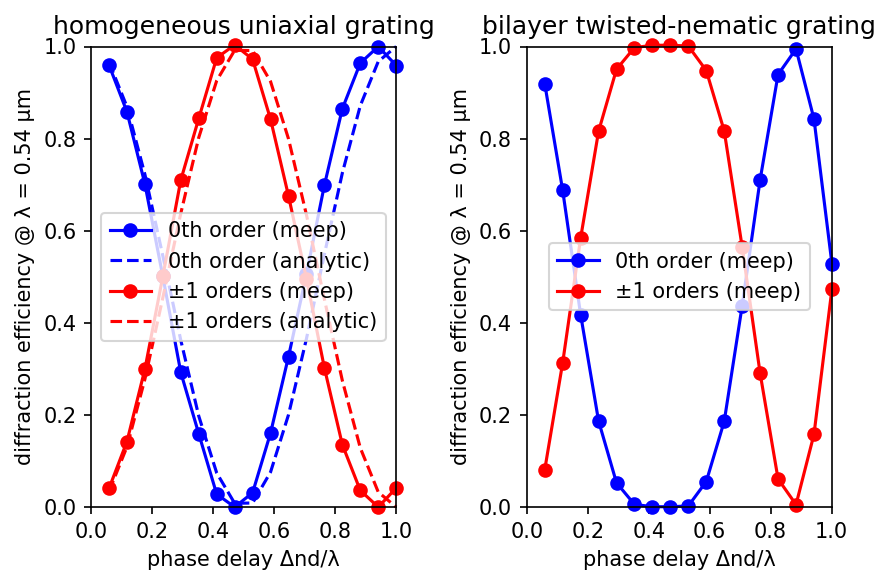

In [4]:
plt.figure(dpi=150)
plt.subplot(1, 2, 1)
plt.plot(phase, eff_m0, "bo-", clip_on=False, label="0th order (meep)")
plt.plot(phase, eff_m0_analytic, "b--", clip_on=False, label="0th order (analytic)")
plt.plot(phase, eff_m1, "ro-", clip_on=False, label="±1 orders (meep)")
plt.plot(phase, eff_m1_analytic, "r--", clip_on=False, label="±1 orders (analytic)")
plt.axis([0, 1.0, 0, 1])
plt.xticks([t for t in np.arange(0, 1.2, 0.2)])
plt.xlabel("phase delay Δnd/λ")
plt.ylabel("diffraction efficiency @ λ = 0.54 μm")
plt.legend(loc="center")
plt.title("homogeneous uniaxial grating")

cos_angles = [math.cos(math.radians(t)) for t in ang_twisted]
tran = m0_twisted + 2 * m1_twisted
eff_m0 = m0_twisted / tran
eff_m1 = (2 * m1_twisted / tran) / cos_angles

plt.subplot(1, 2, 2)
plt.plot(phase, eff_m0, "bo-", clip_on=False, label="0th order (meep)")
plt.plot(phase, eff_m1, "ro-", clip_on=False, label="±1 orders (meep)")
plt.axis([0, 1.0, 0, 1])
plt.xticks([t for t in np.arange(0, 1.2, 0.2)])
plt.xlabel("phase delay Δnd/λ")
plt.ylabel("diffraction efficiency @ λ = 0.54 μm")
plt.legend(loc="center")
plt.title("bilayer twisted-nematic grating")

plt.tight_layout()
plt.show()

The left figure shows good agreement between the simulation results and analytic theory for the homogeneous uniaxial grating. Approximately 6% of the power in the input planewave is lost due to reflection from the grating. This value is an average over all phase delays. The total transmittance is therefore around 94%. The twisted-nematic grating, with results shown in the right figure, produces ±1 diffraction orders with nearly-constant peak transmittance over a broader bandwidth around Δnd/λ=0.5 than the homogeneous uniaxial polarization grating. This is consistent with results from the reference. The average reflectance and transmittance for the twisted-nematic grating are similar to those for the homogeneous uniaxial grating.

Finally, we demonstrate that when Δnd/λ=0.5 a circular-polarized planewave input produces just a single ±1 diffraction order. To specify a E<sub>z</sub>+iE<sub>y</sub> circular-polarized planewave requires setting the `amplitude` of the E<sub>y</sub> source to an imaginary number (from its default of 1):

```py
sources = [mp.Source(mp.GaussianSource(fcen,fwidth=0.05*fcen), component=mp.Ez, center=src_pt, size=mp.Vector3(0,sy,0)),
           mp.Source(mp.GaussianSource(fcen,fwidth=0.05*fcen), component=mp.Ey, center=src_pt, size=mp.Vector3(0,sy,0), amplitude=1j)]
```

Note that even though the J<sub>y</sub> current amplitude is complex in this example, only its real part is used and the resulting fields are therefore still real (the default).

The figure below shows a snapshot of E<sub>z</sub> within the cell for four different cases: phase delays (Δnd/λ) of 0.5 and 1.0, and planewave circular polarization of E<sub>z</sub>+iE<sub>y</sub> and E<sub>z</sub>-iE<sub>y</sub>. The empty regions on the cell sides are PMLs. The thin solid black line denotes the boundary between the grating (on the left) and air. As expected, for Δnd/λ=0.5 there is just a single ±1 diffraction order which depends on the chirality of the input planewave (this is not the case for a linear-polarized planewave). The angle of this diffracted order (±4.8°) agrees with the analytic result. Snapshots of E<sub>y</sub> are similar.

![](https://meep.readthedocs.io/en/latest/images/polarization_grating_diffraction_orders.png)